In [1]:
!pip install pytorch_metric_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 4.1 MB/s eta 0:00:00


In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [3]:
import torchvision
import numpy as np

# Define transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5 ,0.5), (0.5,0.5,0.5))])

import torch.utils.data as data

# Define the transform to apply to the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR-10 training and test datasets separately
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Combine the training and test datasets into a single dataset
dataset = torch.utils.data.ConcatDataset([trainset, testset])

# Create a dataloader for the combined dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Print the shapes of the loaded data
print('Combined Images:', len(dataset))
print('Combined Labels:', len(trainset.targets) + len(testset.targets))
dataset.targets = trainset.targets + testset.targets

100%|██████████| 170498071/170498071 [00:01<00:00, 104469249.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Combined Images: 60000
Combined Labels: 60000


In [4]:
# Split indices into train, val, and test sets
np.random.seed(42)
train_indices = np.arange(len(dataset))
np.random.shuffle(train_indices)
test_indices = np.arange(len(dataset))

train_size = 12000
val_size = 48000


train_indices = []
val_indices = []

for i in range(10):
    class_indices = np.where(np.array(dataset.targets) == i)[0]
    np.random.shuffle(class_indices)
    train_indices.extend(class_indices[:1200])
    val_indices.extend(class_indices[1200:6000])

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

In [19]:
# batch sampler source: https://github.com/leeesangwon/PyTorch-Image-Retrieval/blob/public/datasets.py
class BalancedBatchSampler(BatchSampler):
    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size <= len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size
    



batch_sampler = BalancedBatchSampler(torch.utils.data.Subset(dataset, train_indices), n_classes=10, n_samples=10)

In [20]:
batch_size = 128
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_indices), batch_sampler=batch_sampler)

#train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, train_indices), batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, val_indices), batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, test_indices), batch_size=128, shuffle=False, num_workers=2)

train_loader.pin_memory = True
val_loader.pin_memory = True
test_loader.pin_memory = True

In [32]:
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 128)  # add a 128-dimension fully connected layer
model.to(device)

# Define the loss function and the miner
loss_fn = losses.AngularLoss()
miner = miners.AngularMiner()

# Define the optimizer and the learning rate scheduler
optimizer = Adam(model.parameters(), lr=0.001)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 250], gamma=0.1)


losses1 = []

model.train()
for epoch in range(80):
    total_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            images = images.to(device)
            labels = labels.to(device)
            embeddings = nn.functional.normalize(model(images),dim=1)
            indices_tuple = miner(embeddings, labels)
            loss = loss_fn(embeddings, labels, indices_tuple)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update progress bar
            tepoch.set_postfix(loss=total_loss/len(train_loader))
    losses1.append(total_loss/len(train_loader))        
    #lr_scheduler.step()
    print('Epoch: {}, Loss: {}'.format(epoch+1, total_loss/len(train_loader)))


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 120/120 [00:07<00:00, 17.08batch/s, loss=4.5]


Epoch: 1, Loss: 4.503840390841166


100%|██████████| 120/120 [00:06<00:00, 19.07batch/s, loss=4.44]


Epoch: 2, Loss: 4.441869644323985


100%|██████████| 120/120 [00:06<00:00, 17.33batch/s, loss=4.39]


Epoch: 3, Loss: 4.394627026716868


100%|██████████| 120/120 [00:06<00:00, 18.57batch/s, loss=4.34]


Epoch: 4, Loss: 4.338399112224579


100%|██████████| 120/120 [00:06<00:00, 18.18batch/s, loss=4.27]


Epoch: 5, Loss: 4.270382330814997


100%|██████████| 120/120 [00:06<00:00, 19.72batch/s, loss=4.21]


Epoch: 6, Loss: 4.2118774632612865


100%|██████████| 120/120 [00:06<00:00, 18.39batch/s, loss=4.16]


Epoch: 7, Loss: 4.161448554197947


100%|██████████| 120/120 [00:06<00:00, 19.60batch/s, loss=4.12]


Epoch: 8, Loss: 4.1162720084190365


100%|██████████| 120/120 [00:06<00:00, 18.75batch/s, loss=4.11]


Epoch: 9, Loss: 4.113869921366374


100%|██████████| 120/120 [00:06<00:00, 19.11batch/s, loss=4.06]


Epoch: 10, Loss: 4.064313248793284


100%|██████████| 120/120 [00:06<00:00, 18.84batch/s, loss=3.97]


Epoch: 11, Loss: 3.9738228003184


100%|██████████| 120/120 [00:06<00:00, 19.24batch/s, loss=3.96]


Epoch: 12, Loss: 3.9574092090129853


100%|██████████| 120/120 [00:06<00:00, 19.26batch/s, loss=3.86]


Epoch: 13, Loss: 3.858592959245046


100%|██████████| 120/120 [00:06<00:00, 19.47batch/s, loss=3.88]


Epoch: 14, Loss: 3.8838605920473737


100%|██████████| 120/120 [00:06<00:00, 19.26batch/s, loss=3.83]


Epoch: 15, Loss: 3.832039741675059


100%|██████████| 120/120 [00:06<00:00, 19.08batch/s, loss=3.74]


Epoch: 16, Loss: 3.7370268285274504


100%|██████████| 120/120 [00:06<00:00, 19.26batch/s, loss=3.76]


Epoch: 17, Loss: 3.757861969868342


100%|██████████| 120/120 [00:06<00:00, 19.00batch/s, loss=3.76]


Epoch: 18, Loss: 3.755946336189906


100%|██████████| 120/120 [00:06<00:00, 19.69batch/s, loss=3.64]


Epoch: 19, Loss: 3.6362872044245402


100%|██████████| 120/120 [00:06<00:00, 18.68batch/s, loss=3.69]


Epoch: 20, Loss: 3.6925577402114866


100%|██████████| 120/120 [00:06<00:00, 19.25batch/s, loss=3.59]


Epoch: 21, Loss: 3.5949282546838126


100%|██████████| 120/120 [00:06<00:00, 19.06batch/s, loss=3.48]


Epoch: 22, Loss: 3.478758947054545


100%|██████████| 120/120 [00:06<00:00, 19.69batch/s, loss=3.59]


Epoch: 23, Loss: 3.587262870868047


100%|██████████| 120/120 [00:06<00:00, 18.93batch/s, loss=3.52]


Epoch: 24, Loss: 3.5160997172196704


100%|██████████| 120/120 [00:06<00:00, 19.78batch/s, loss=3.44]


Epoch: 25, Loss: 3.4429153323173525


100%|██████████| 120/120 [00:06<00:00, 19.00batch/s, loss=3.42]


Epoch: 26, Loss: 3.417754501104355


100%|██████████| 120/120 [00:06<00:00, 19.88batch/s, loss=3.37]


Epoch: 27, Loss: 3.365019636352857


100%|██████████| 120/120 [00:06<00:00, 19.18batch/s, loss=3.42]


Epoch: 28, Loss: 3.4181818743546803


100%|██████████| 120/120 [00:06<00:00, 19.52batch/s, loss=3.26]


Epoch: 29, Loss: 3.2561641573905944


100%|██████████| 120/120 [00:06<00:00, 19.00batch/s, loss=3.42]


Epoch: 30, Loss: 3.418846180041631


100%|██████████| 120/120 [00:06<00:00, 19.57batch/s, loss=3.24]


Epoch: 31, Loss: 3.2424059212207794


100%|██████████| 120/120 [00:06<00:00, 19.34batch/s, loss=3.12]


Epoch: 32, Loss: 3.1234109540780386


100%|██████████| 120/120 [00:06<00:00, 19.49batch/s, loss=3.33]


Epoch: 33, Loss: 3.3344333291053774


100%|██████████| 120/120 [00:06<00:00, 18.74batch/s, loss=3.17]


Epoch: 34, Loss: 3.165179525812467


100%|██████████| 120/120 [00:06<00:00, 19.91batch/s, loss=3.07]


Epoch: 35, Loss: 3.069666798909505


100%|██████████| 120/120 [00:06<00:00, 18.99batch/s, loss=3.11]


Epoch: 36, Loss: 3.1089267045259477


100%|██████████| 120/120 [00:06<00:00, 19.31batch/s, loss=2.91]


Epoch: 37, Loss: 2.9145079890886945


100%|██████████| 120/120 [00:06<00:00, 19.27batch/s, loss=2.83]


Epoch: 38, Loss: 2.827542835474014


100%|██████████| 120/120 [00:06<00:00, 19.69batch/s, loss=3.03]


Epoch: 39, Loss: 3.0260493318239847


100%|██████████| 120/120 [00:06<00:00, 19.53batch/s, loss=2.7]


Epoch: 40, Loss: 2.7014378984769185


100%|██████████| 120/120 [00:06<00:00, 19.57batch/s, loss=2.95]


Epoch: 41, Loss: 2.948022761940956


100%|██████████| 120/120 [00:06<00:00, 19.46batch/s, loss=2.86]


Epoch: 42, Loss: 2.857389392455419


100%|██████████| 120/120 [00:06<00:00, 19.30batch/s, loss=2.98]


Epoch: 43, Loss: 2.9787363688151043


100%|██████████| 120/120 [00:06<00:00, 19.86batch/s, loss=2.63]


Epoch: 44, Loss: 2.628917344411214


100%|██████████| 120/120 [00:06<00:00, 19.42batch/s, loss=2.51]


Epoch: 45, Loss: 2.5084304263194404


100%|██████████| 120/120 [00:06<00:00, 19.86batch/s, loss=2.52]


Epoch: 46, Loss: 2.522733575105667


100%|██████████| 120/120 [00:06<00:00, 19.08batch/s, loss=2.65]


Epoch: 47, Loss: 2.65490216811498


100%|██████████| 120/120 [00:05<00:00, 20.13batch/s, loss=2.42]


Epoch: 48, Loss: 2.418615588545799


100%|██████████| 120/120 [00:06<00:00, 18.78batch/s, loss=2.56]


Epoch: 49, Loss: 2.555328153570493


100%|██████████| 120/120 [00:06<00:00, 19.74batch/s, loss=2.55]


Epoch: 50, Loss: 2.550512844324112


100%|██████████| 120/120 [00:06<00:00, 19.21batch/s, loss=2.43]


Epoch: 51, Loss: 2.4274925847848254


100%|██████████| 120/120 [00:05<00:00, 20.49batch/s, loss=2.43]


Epoch: 52, Loss: 2.4321600089470548


100%|██████████| 120/120 [00:06<00:00, 19.08batch/s, loss=2.18]


Epoch: 53, Loss: 2.177417266368866


100%|██████████| 120/120 [00:05<00:00, 20.86batch/s, loss=2.16]


Epoch: 54, Loss: 2.156051371494929


100%|██████████| 120/120 [00:06<00:00, 18.58batch/s, loss=2.07]


Epoch: 55, Loss: 2.0689610024293263


100%|██████████| 120/120 [00:05<00:00, 20.66batch/s, loss=1.94]


Epoch: 56, Loss: 1.9374224136273066


100%|██████████| 120/120 [00:06<00:00, 18.35batch/s, loss=2.2]


Epoch: 57, Loss: 2.1971896280845007


100%|██████████| 120/120 [00:05<00:00, 20.92batch/s, loss=1.95]


Epoch: 58, Loss: 1.9480686316887537


100%|██████████| 120/120 [00:06<00:00, 18.67batch/s, loss=1.9]


Epoch: 59, Loss: 1.8970598836739858


100%|██████████| 120/120 [00:05<00:00, 20.82batch/s, loss=2.04]


Epoch: 60, Loss: 2.039773855606715


100%|██████████| 120/120 [00:06<00:00, 18.67batch/s, loss=2.15]


Epoch: 61, Loss: 2.146525458494822


100%|██████████| 120/120 [00:05<00:00, 20.59batch/s, loss=2.17]


Epoch: 62, Loss: 2.1659424205621085


100%|██████████| 120/120 [00:06<00:00, 19.00batch/s, loss=2.16]


Epoch: 63, Loss: 2.162784649928411


100%|██████████| 120/120 [00:05<00:00, 21.05batch/s, loss=1.97]


Epoch: 64, Loss: 1.9721748967965445


100%|██████████| 120/120 [00:06<00:00, 18.63batch/s, loss=2.27]


Epoch: 65, Loss: 2.2705611765384672


100%|██████████| 120/120 [00:05<00:00, 20.61batch/s, loss=2.16]


Epoch: 66, Loss: 2.155139235655467


100%|██████████| 120/120 [00:06<00:00, 18.81batch/s, loss=2.24]


Epoch: 67, Loss: 2.236681252717972


100%|██████████| 120/120 [00:05<00:00, 20.94batch/s, loss=1.92]


Epoch: 68, Loss: 1.918752881884575


100%|██████████| 120/120 [00:06<00:00, 18.67batch/s, loss=1.84]


Epoch: 69, Loss: 1.8448162416617075


100%|██████████| 120/120 [00:05<00:00, 20.84batch/s, loss=1.71]


Epoch: 70, Loss: 1.7069825838009516


100%|██████████| 120/120 [00:06<00:00, 18.58batch/s, loss=1.62]


Epoch: 71, Loss: 1.6183376202980677


100%|██████████| 120/120 [00:05<00:00, 20.99batch/s, loss=1.58]


Epoch: 72, Loss: 1.5813260436058045


100%|██████████| 120/120 [00:06<00:00, 18.69batch/s, loss=1.77]


Epoch: 73, Loss: 1.7740645269552866


100%|██████████| 120/120 [00:05<00:00, 21.15batch/s, loss=1.75]


Epoch: 74, Loss: 1.745483257373174


100%|██████████| 120/120 [00:06<00:00, 18.87batch/s, loss=1.41]


Epoch: 75, Loss: 1.4149504472812018


100%|██████████| 120/120 [00:05<00:00, 20.78batch/s, loss=1.77]


Epoch: 76, Loss: 1.770628313223521


100%|██████████| 120/120 [00:06<00:00, 18.58batch/s, loss=1.94]


Epoch: 77, Loss: 1.936755621433258


100%|██████████| 120/120 [00:05<00:00, 20.87batch/s, loss=1.68]


Epoch: 78, Loss: 1.677515271306038


100%|██████████| 120/120 [00:06<00:00, 18.84batch/s, loss=1.58]


Epoch: 79, Loss: 1.5795866469542186


100%|██████████| 120/120 [00:05<00:00, 20.86batch/s, loss=1.5]

Epoch: 80, Loss: 1.4968638022740681


<ipython-input-44-8ea029a47e9d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


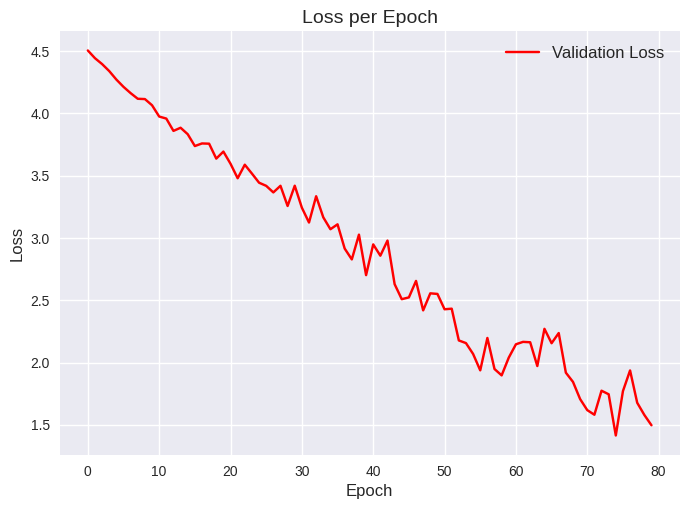

In [44]:
import matplotlib.style as style
import matplotlib as plt
style.use('seaborn')
import matplotlib.pyplot as plt

plt.figure()


plt.plot(losses1, label="Validation Loss", color = "red")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss per Epoch", fontsize=14)
plt.style.use("ggplot")
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [33]:
# Test the model using k-NN
model.eval()
embeddings = []
labels = []
with torch.no_grad():
    for images, batch_labels in train_loader:
        images = images.to(device)
        batch_embeddings = nn.functional.normalize(model(images),dim=1)
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)
knn = KNeighborsClassifier()
knn.fit(embeddings, labels)

# Test the model using k-NN
model.eval()
embeddings = []
labels = []
with torch.no_grad():
    for images, batch_labels in test_loader:
        images = images.to(device)
        batch_embeddings = nn.functional.normalize(model(images),dim=1)
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)


accuracy = knn.score(embeddings, labels)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.7896


In [50]:
# Test the model using k-NN on perturbed test data

import matplotlib.pyplot as plt
import random
def pixelchange(x):
    for _ in range(10):
        x[0][int(random.random()*32)][int(random.random()*32)] = 1
        x[1][int(random.random()*32)][int(random.random()*32)] = 1
        x[2][int(random.random()*32)][int(random.random()*32)] = 1
    return x


# Define the new transformations
test_transform_perturbate = transforms.Compose([
    transforms.ColorJitter(brightness=0.6, contrast=0.5, saturation=0.2, hue=0),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: pixelchange(x)),
    transforms.Normalize((0.5, 0.5 ,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=test_transform_perturbate)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform_perturbate)

# Combine the training and test datasets into a single dataset
dataset_corrupted = torch.utils.data.ConcatDataset([trainset, testset])


# Apply the new transformations to the test dataset
val_loader_perturbate = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset_corrupted, val_indices), batch_size=128, shuffle=False, num_workers=2)

      
model.eval()
embeddings = []
labels = []
with torch.no_grad():
    for images, batch_labels in val_loader_perturbate:
        images = images.to(device)
        batch_embeddings = nn.functional.normalize(model(images),dim=1)
        embeddings.append(batch_embeddings.cpu().numpy())
        labels.append(batch_labels.numpy())
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)


accuracy = knn.score(embeddings, labels)
print('Accuracy: {}'.format(accuracy))

Files already downloaded and verified
Files already downloaded and verified
Accuracy: 0.5253125


In [55]:
!pip install cleverhans
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.0 MB/s eta 0:00:00


In [34]:
!pip install -q umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


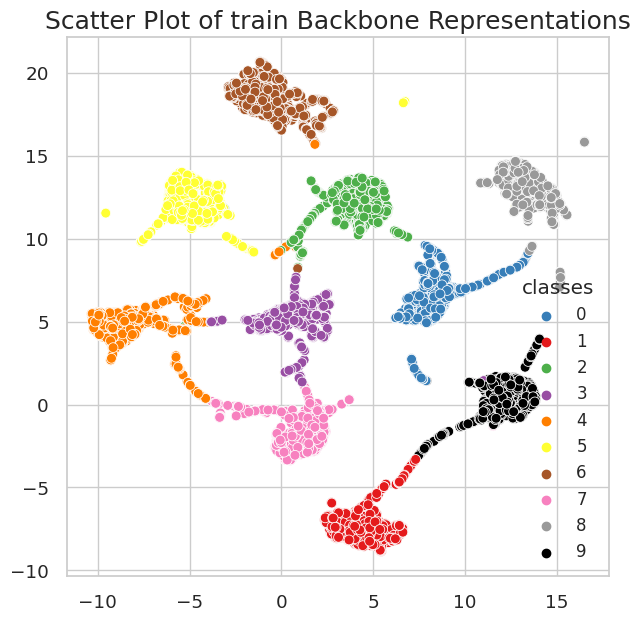

In [53]:
import umap.umap_ as umap
import numpy as np

# Assuming you have a DataLoader called 'dataloader' that loads your data
embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = nn.functional.normalize(model(inputs),dim=-1)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP
reducer = umap.UMAP()
embeddings_2d = reducer.fit(embeddings)
train_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt


import seaborn as sns

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=train_emb[:, 0], y=train_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of train Backbone Representations', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()

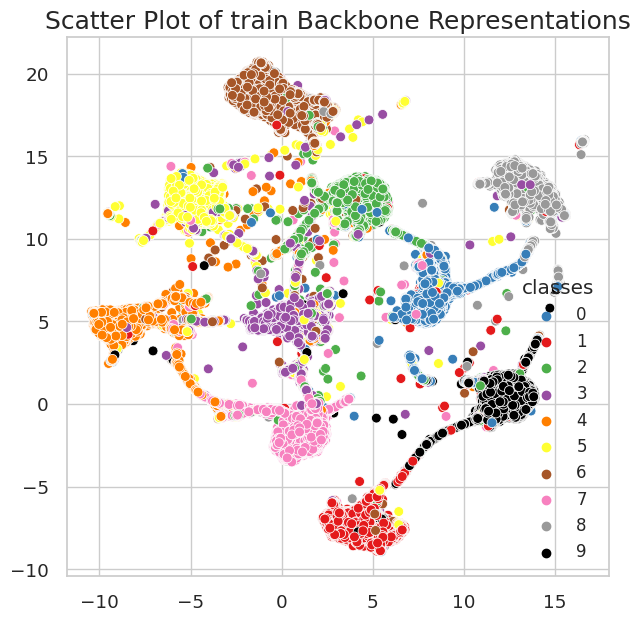

In [54]:
import umap.umap_ as umap
import numpy as np

# Assuming you have a DataLoader called 'dataloader' that loads your data
embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = nn.functional.normalize(model(inputs),dim=-1)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP

test_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt


import seaborn as sns

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=test_emb[:, 0], y=test_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of train Backbone Representations', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()

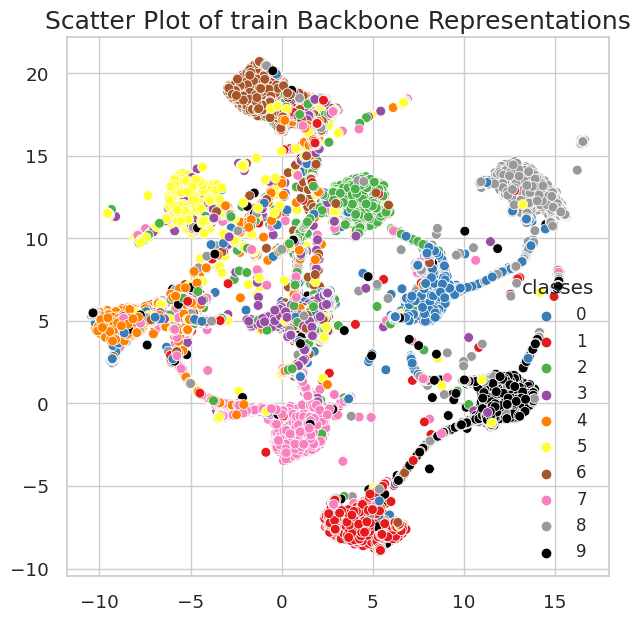

In [58]:
import umap.umap_ as umap
import numpy as np

# Assuming you have a DataLoader called 'dataloader' that loads your data
embeddings = []
labels = []
with torch.no_grad():
    for inputs, targets in val_loader_perturbate:
        inputs = inputs.to(device)
        targets = targets.to(device)
        feats = nn.functional.normalize(model(inputs),dim=-1)
        feats = feats.view(feats.size(0), -1)
        embeddings.append(feats.cpu().numpy())
        labels.append(targets.cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Reduce the dimensionality of the embeddings to 2 using UMAP
train_emb = reducer.transform(embeddings)
import matplotlib.pyplot as plt


import seaborn as sns

sns.set(style='whitegrid', font_scale=1.2)

# Create scatter plot with customized marker size and color scheme
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
          '#ffff33', '#a65628', '#f781bf', '#999999', '#000000']
plt.figure(figsize=(7, 7))
sns.scatterplot(x=train_emb[:, 0], y=train_emb[:, 1], hue=labels, s=50, palette=colors)

# Add axis labels and title
plt.title('Scatter Plot of train Backbone Representations', fontsize=18)

# Add legend
plt.legend(title='classes', loc='best', fontsize=12)

# Add grid lines
plt.grid(True)

        
# Show the plot
plt.show()